# Test gluon tools with egg data

## 24/02/21
- data path: 'SplitProf-obj-detect-240221/'
    - use all egg data
    - split by profile
    - subset copepods so even ratio
    - test data preserves natural distribution
- network backbone: MobileNet
- train mode: finetune from ImageNet weights
- epochs: 10

In [1]:
import numpy as np
import mxnet as mx
from mxnet import autograd, gluon
import gluoncv as gcv
import argparse
import sys
from gluoncv.utils import viz
from gluoncv.data import VOCDetection
from gluoncv.data.batchify import Tuple, Stack, Pad
from gluoncv.data.transforms.presets.ssd import SSDDefaultTrainTransform, SSDDefaultValTransform
from gluoncv.utils.metrics.voc_detection import VOC07MApMetric
from gluoncv.data.pascal_voc.detection import CustomVOCDetectionBase

In [2]:
from finetune import get_dataloader, validate, train

## Preliminaries
Load in pre-trained SSD with mobilenet backbone

In [3]:
net = gcv.model_zoo.get_model('ssd_512_mobilenet1.0_voc', pretrained=True)

/home/eorenstein/anaconda3/envs/mx-gluon/lib/python3.6/site-packages/mxnet/gluon/block.py:1512: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


Define a few file paths, etc

In [4]:
rt = '/home/eorenstein/'
voc_base = 'VOCCopepodEgg'
img_list = 'SplitProf-obj-detect-240221/'
cl = ('copepod', 'eggs') 

Load in the appropriate datasets

In [5]:
train_dataset = CustomVOCDetectionBase(classes=cl,
                          root=rt, 
                          splits=((voc_base,f'{img_list}/train'),))
val_dataset =CustomVOCDetectionBase(classes=cl,
                          root=rt, 
                          splits=((voc_base,f'{img_list}/val'),))

Define the training metric

In [6]:
val_metric = VOC07MApMetric(iou_thresh=0.5, class_names=val_dataset.classes)

Find and activate the GPU

In [7]:
contx = [mx.gpu(0)]
print('GPU found')

GPU found


Put the network on the GPU and reset the classes

In [8]:
net.collect_params().reset_ctx(contx)
net.reset_class(val_dataset.classes)

Set up the dataloader that will pass the images to the GPU. Hardcode data shape (IE shape in pixels that the image will be resize to), batch size, and the number of workers (CPU threads for data preprocessing).

In [9]:
train_data, val_data = get_dataloader(net, train_dataset, val_dataset, 512, 16, 0,
                                      contx[0])

## Train
Actually run the training. Hardcode the number of epochs and how often to run validation.

In [10]:
train(net, train_data, val_data, val_metric, contx, 10, 2)

[Epoch 0][Batch 0], Speed: 2.271 samples/sec, CrossEntropy=14.321, SmoothL1=1.746
[Epoch 0][Batch 20], Speed: 33.791 samples/sec, CrossEntropy=5.809, SmoothL1=1.545
[Epoch 0][Batch 40], Speed: 36.022 samples/sec, CrossEntropy=4.499, SmoothL1=1.371
[Epoch 0][Batch 60], Speed: 36.565 samples/sec, CrossEntropy=3.917, SmoothL1=1.251
[Epoch 0][Batch 80], Speed: 35.824 samples/sec, CrossEntropy=3.580, SmoothL1=1.192
[Epoch 0][Batch 100], Speed: 37.286 samples/sec, CrossEntropy=3.342, SmoothL1=1.139
[Epoch 0][Batch 120], Speed: 36.855 samples/sec, CrossEntropy=3.176, SmoothL1=1.100
[Epoch 0][Batch 140], Speed: 37.961 samples/sec, CrossEntropy=3.047, SmoothL1=1.077
copepod=0.8967020030117395
eggs=0.11186800173806666
mAP=0.504285002374903
[Epoch 1][Batch 0], Speed: 34.761 samples/sec, CrossEntropy=1.910, SmoothL1=0.723
[Epoch 1][Batch 20], Speed: 35.049 samples/sec, CrossEntropy=2.163, SmoothL1=0.886
[Epoch 1][Batch 40], Speed: 36.278 samples/sec, CrossEntropy=2.150, SmoothL1=0.865
[Epoch 1][Ba

## Test
Define a data loader for the test data

In [12]:
def test_dataloader(net, t_data, data_shape, batch_size, num_workers, ctx):
    """Get dataloader."""
    width, height = data_shape, data_shape
    
    test_batchify_fn = Tuple(Stack(), Pad(pad_val=-1))
    
    # the validation loader 
    test_loader = gluon.data.DataLoader(
        t_data.transform(SSDDefaultValTransform(width, height)),
        batch_size, False, batchify_fn=test_batchify_fn, last_batch='keep',
        num_workers=num_workers)
    
    return test_loader


Load test data

In [13]:
test_dataset = CustomVOCDetectionBase(classes=cl,
                          root=rt, 
                          splits=((voc_base,f'{img_list}/test'),))
test_data = test_dataloader(net, test_dataset, 512, 16, 0, contx[0])

Use the validation metric and validate function from above to crank the test data through the trained network

In [14]:
map_name, mean_ap = validate(net, test_data, contx, val_metric)
val_msg = '\n'.join(['{}={}'.format(k, v) for k, v in zip(map_name, mean_ap)])

# print the output
print(val_msg)

copepod=0.9511507910677633
eggs=0.7294234646282359
mAP=0.8402871278479996


## Display

Grab some images that have eggs in them from the test set and look at the output. 

In [28]:
import os
ptf = os.path.join(rt,'VOCCopepodEgg/ImageSets/Main/SplitByProfile-230221/egg_test.txt')

with open(ptf, 'r') as ff:
    test_eggs = list(ff)
    ff.close()
    
test_eggs = [os.path.join(rt,voc_base, 'JPEGImages',line.strip()+'.jpg')
             for line in test_eggs]

print(len(test_eggs))

266


Search for the biggest ROI for easy visualization

In [33]:
from PIL import Image

def get_dim(img):
    """
    return biggest of image dimensions
    :param img: absolute path to image [str]
    :return: max(width, height) [int]
    """
    im = Image.open(img)
    wid, hgt = im.size
    return [wid, hgt]

big_dim = 0
idx = 0
for ii in range(len(test_eggs)):
    xx = get_dim(test_eggs[ii])
    if np.max(xx) > big_dim:
        big_dim = np.max(xx)
        idx = ii

print(big_dim)
print(idx)

368
41


Load in an image in the appropriate format and display it (it will likely look weird with the transform)

In [25]:
# put the network on cpu for this test
net.collect_params().reset_ctx(mx.cpu(0))

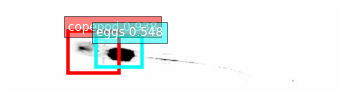

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt

x, img = gcv.data.transforms.presets.ssd.load_test(test_eggs[41], 512)

# display
cid, score, bbox = net(x)
ax = viz.plot_bbox(img, bbox[0], score[0], cid[0], class_names=test_dataset.classes)
plt.axis('off')
plt.show()